<a href="https://colab.research.google.com/github/zi-onion/24-2-ESAA/blob/main/9_13_%E1%84%89%E1%85%A6%E1%84%89%E1%85%A7%E1%86%AB_%E1%84%86%E1%85%A9%E1%84%83%E1%85%A6%E1%86%AF%E1%84%92%E1%85%AE%E1%86%AB%E1%84%85%E1%85%A7%E1%86%AB_%E1%84%8B%E1%85%A7%E1%86%AB%E1%84%89%E1%85%B3%E1%86%B8%E1%84%86%E1%85%AE%E1%86%AB%E1%84%8C%E1%85%A6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **모델 훈련 연습 문제**
___
- 출처 : 핸즈온 머신러닝 Ch04 연습문제 1, 5, 9, 10
- 개념 문제의 경우 텍스트 셀을 추가하여 정답을 적어주세요.

### **1. 수백만 개의 특성을 가진 훈련 세트에서는 어떤 선형 회귀 알고리즘을 사용할 수 있을까요?**
___


확률적 경사 하강법이나 미니배치 경사 하강법 혹은 배치 경사 하강법을 사용할 수 있다.

### **2. 배치 경사 하강법을 사용하고 에포크마다 검증 오차를 그래프로 나타내봤습니다. 검증 오차가 일정하게 상승되고 있다면 어떤 일이 일어나고 있는 걸까요? 이 문제를 어떻게 해결할 수 있나요?**
___

과적합이 발생하고 있는 것이다. 훈련을 멈추어야 한다.

### **3. 릿지 회귀를 사용했을 때 훈련 오차가 검증 오차가 거의 비슷하고 둘 다 높았습니다. 이 모델에는 높은 편향이 문제인가요, 아니면 높은 분산이 문제인가요? 규제 하이퍼파라미터 $\alpha$를 증가시켜야 할까요 아니면 줄여야 할까요?**
___

위 문제는 모델이 과소적합되었을 때의 특징으로, 높은 편향을 가진다고 할 수 있다. 하이퍼파라미터 $\alpha$를 줄여야한다.

### **4. 다음과 같이 사용해야 하는 이유는?**
___
- 평범한 선형 회귀(즉, 아무런 규제가 없는 모델) 대신 릿지 회귀
- 릿지 회귀 대신 라쏘 회귀
- 라쏘 회귀 대신 엘라스틱넷

* 릿지회귀는 기존 선형회귀에 규제항을 추가하여 성능을 좋게 만들기 때문
* 라쏘회귀의 특징은 덜 중요한 특성을 가중치 0으로 만들어준다는 점이다. 몇몇 특성만이 영향을 미치고 있는 것 같다면 릿지대신 라쏘를 사용하는 것이 더 좋다.
* 두 모델 모두 덜 중요한 가중치를 0으로 만드는 특징이 있다. 다만, 그 특성이 강하게 영향을 미치는 경우에는 라쏘에서 오류(문제)가 생기기 쉬우므로 엘라스틱넷을 사용하게 된다.

### **추가) 조기 종료를 사용한 배치 경사 하강법으로 iris 데이터를 활용해 소프트맥스 회귀를 구현해보세요(사이킷런은 사용하지 마세요)**


---



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
from sklearn.datasets import load_iris

iris = load_iris()

In [4]:
X = iris['data'][:,(2,3)] # 꽃잎 길이, 꽃잎 넓이
y = iris['target']

In [6]:
# 샘플에 편향 추가
X_with_bias = np.c_[np.ones([len(X), 1]), X]

In [27]:
np.random.seed(2042)

In [28]:
test_ratio = 0.2
validation_ratio = 0.2
total_size = len(X_with_bias)

test_size = int(total_size * test_ratio)
validation_size = int(total_size * validation_ratio)
train_size = total_size - test_size - validation_size

rnd_indices = np.random.permutation(total_size)

X_train = X_with_bias[rnd_indices[:train_size]]
y_train = y[rnd_indices[:train_size]]
X_valid = X_with_bias[rnd_indices[train_size:-test_size]]
y_valid = y[rnd_indices[train_size:-test_size]]
X_test = X_with_bias[rnd_indices[-test_size:]]
y_test = y[rnd_indices[-test_size:]]

In [29]:
# 원핫인코딩
def to_one_hot(y):
    n_classes = y.max() + 1
    m = len(y)
    Y_one_hot = np.zeros((m, n_classes))
    Y_one_hot[np.arange(m), y] = 1
    return Y_one_hot

예시

In [30]:
y_train[:10]

array([0, 1, 2, 0, 2, 1, 2, 2, 1, 0])

In [31]:
to_one_hot(y_train[:10])

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.]])

-> 제대로 작동함.

In [32]:
Y_train_one_hot = to_one_hot(y_train)
Y_valid_one_hot = to_one_hot(y_valid)
Y_test_one_hot = to_one_hot(y_test)

In [33]:
#소프트맥스 함수
def softmax(logits):
    exps = np.exp(logits)
    exp_sums = np.sum(exps, axis=1, keepdims=True)
    return exps / exp_sums

In [34]:
n_inputs = X_train.shape[1] # == 3 (특성 2개와 편향)
n_outputs = len(np.unique(y_train))   # == 3 (3개의 붓꽃 클래스)

In [35]:
eta = 0.01
n_iterations = 5001
m = len(X_train)
epsilon = 1e-7

Theta = np.random.randn(n_inputs, n_outputs)

for iteration in range(n_iterations):
    logits = X_train.dot(Theta)
    Y_proba = softmax(logits)
    if iteration % 500 == 0:
        loss = -np.mean(np.sum(Y_train_one_hot * np.log(Y_proba + epsilon), axis=1))
        print(iteration, loss)
    error = Y_proba - Y_train_one_hot
    gradients = 1/m * X_train.T.dot(error)
    Theta = Theta - eta * gradients

0 2.6882976934601923
500 0.8550029713624879
1000 0.6626717898792976
1500 0.5576409012245549
2000 0.4928498288748362
2500 0.4484682459990307
3000 0.4156706226020427
3500 0.3900928586600423
4000 0.3693541481062851
4500 0.35204526960237714
5000 0.337275216265097


In [36]:
Theta

array([[ 3.49036754, -0.80965555, -2.40165809],
       [-1.29828856,  0.17758473, -0.48077112],
       [-1.70218961, -1.44558342,  1.56702831]])

In [37]:
# valid set
logits = X_valid.dot(Theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

accuracy_score = np.mean(y_predict == y_valid)
accuracy_score

0.8333333333333334

In [38]:
#규제 추가
eta = 0.1
n_iterations = 5001
m = len(X_train)
epsilon = 1e-7
alpha = 0.1  # 규제 하이퍼파라미터

Theta = np.random.randn(n_inputs, n_outputs)

for iteration in range(n_iterations):
    logits = X_train.dot(Theta)
    Y_proba = softmax(logits)
    if iteration % 500 == 0:
        xentropy_loss = -np.mean(np.sum(Y_train_one_hot * np.log(Y_proba + epsilon), axis=1))
        l2_loss = 1/2 * np.sum(np.square(Theta[1:]))
        loss = xentropy_loss + alpha * l2_loss
        print(iteration, loss)
    error = Y_proba - Y_train_one_hot
    gradients = 1/m * X_train.T.dot(error) + np.r_[np.zeros([1, n_outputs]), alpha * Theta[1:]]
    Theta = Theta - eta * gradients

0 2.5027956598612957
500 0.5145615469673654
1000 0.4876514939716836
1500 0.47993388348352434
2000 0.47705933734316525
2500 0.47588963497503534
3000 0.47539235911433153
3500 0.47517562668742286
4000 0.47507972933528064
4500 0.4750368920912104
5000 0.4750176388988756


In [39]:
logits = X_valid.dot(Theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

accuracy_score = np.mean(y_predict == y_valid)
accuracy_score

0.9666666666666667

-> 완벽.

In [40]:
# 조기종료 추가
eta = 0.1
n_iterations = 5001
m = len(X_train)
epsilon = 1e-7
alpha = 0.1  # 규제 하이퍼파라미터
best_loss = np.infty

Theta = np.random.randn(n_inputs, n_outputs)

for iteration in range(n_iterations):
    logits = X_train.dot(Theta)
    Y_proba = softmax(logits)
    error = Y_proba - Y_train_one_hot
    gradients = 1/m * X_train.T.dot(error) + np.r_[np.zeros([1, n_outputs]), alpha * Theta[1:]]
    Theta = Theta - eta * gradients

    logits = X_valid.dot(Theta)
    Y_proba = softmax(logits)
    xentropy_loss = -np.mean(np.sum(Y_valid_one_hot * np.log(Y_proba + epsilon), axis=1))
    l2_loss = 1/2 * np.sum(np.square(Theta[1:]))
    loss = xentropy_loss + alpha * l2_loss
    if iteration % 500 == 0:
        print(iteration, loss)
    if loss < best_loss:
        best_loss = loss
    else:
        print(iteration - 1, best_loss)
        print(iteration, loss, "조기 종료!")
        break

0 2.5117575811007464
500 0.5951876803895881
1000 0.5633824728571417
1500 0.5505852638115875
2000 0.5444019087184447
2500 0.5411204900165602
3000 0.5392581171336128
3500 0.538147177779417
4000 0.5374598507527573
4500 0.5370232788081356
5000 0.5367407632033507


In [41]:
logits = X_valid.dot(Theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

accuracy_score = np.mean(y_predict == y_valid)
accuracy_score

0.9666666666666667

-> 더 빠르게 수행됨

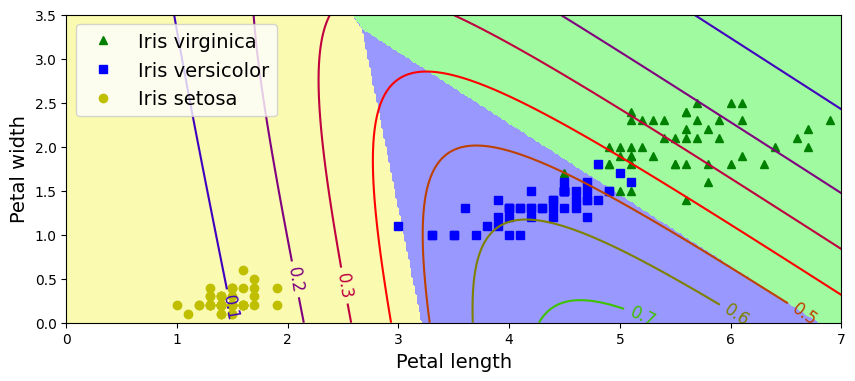

In [42]:
# 그래프 그리기

x0, x1 = np.meshgrid(
        np.linspace(0, 8, 500).reshape(-1, 1),
        np.linspace(0, 3.5, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]
X_new_with_bias = np.c_[np.ones([len(X_new), 1]), X_new]

logits = X_new_with_bias.dot(Theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

zz1 = Y_proba[:, 1].reshape(x0.shape)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y==2, 0], X[y==2, 1], "g^", label="Iris virginica")
plt.plot(X[y==1, 0], X[y==1, 1], "bs", label="Iris versicolor")
plt.plot(X[y==0, 0], X[y==0, 1], "yo", label="Iris setosa")

from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
contour = plt.contour(x0, x1, zz1, cmap=plt.cm.brg)
plt.clabel(contour, inline=1, fontsize=12)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=14)
plt.axis([0, 7, 0, 3.5])
plt.show()

In [43]:
# test set으로 수행
logits = X_test.dot(Theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

accuracy_score = np.mean(y_predict == y_test)
accuracy_score

0.9333333333333333